# **Homework 1 - ML for Time Series**

### Authors:
- Naïl Khelifa
- Tom Rossa

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [8]:
X = np.random.randn(100, 200)
X.shape

(100, 200)

/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_48892/1832207983.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  autocorr_arr[tau] = (1/N)*np.sum(wg_noise_arr[n]*wg_noise_arr[n+tau] for n in range(N-tau-1))


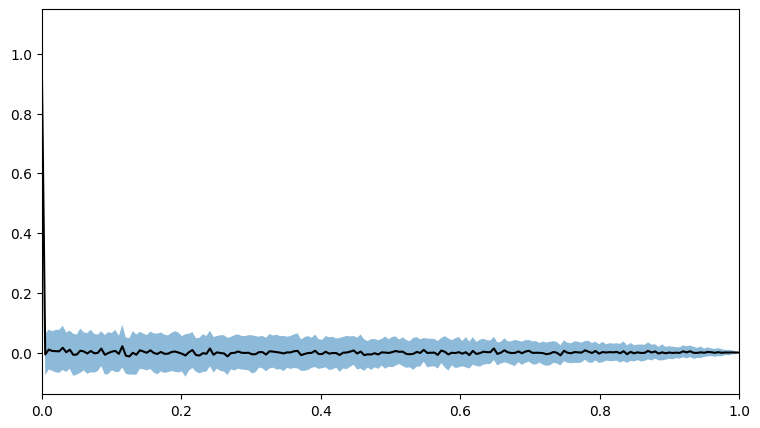

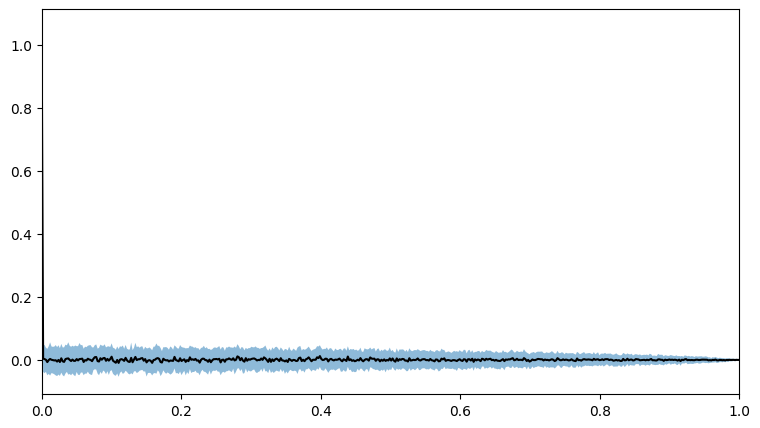

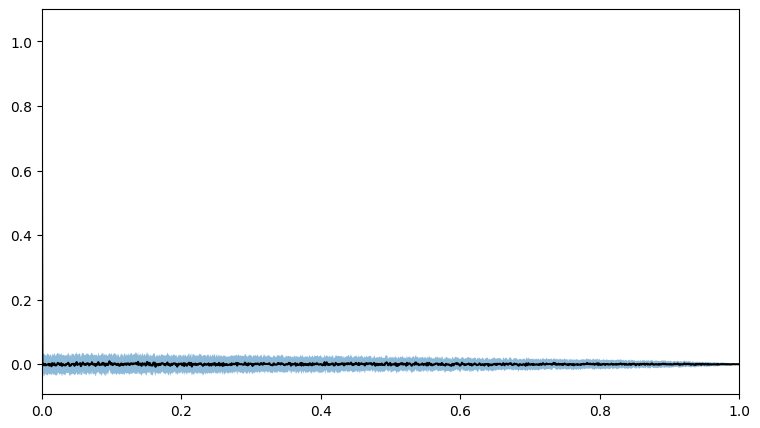

In [11]:
def white_gaussian_noise(N_trials, N_samples):
    return np.random.randn(N_trials, N_samples)

def sample_autocorr_arr(wg_noise_arr):
    # on récupère la longueur du vecteur de bruit (X_0, ..., X_{N-1})
    N = len(wg_noise_arr)

    # on instancie un vecteur vide dans lequel on va stocker gamma(tau) 
    # tau = 0, ..., N-1
    autocorr_arr = np.zeros(N)

    # on remplit ce vecteur
    for tau in range(N):
        autocorr_arr[tau] = (1/N)*np.sum(wg_noise_arr[n]*wg_noise_arr[n+tau] for n in range(N-tau-1))

    # on renvoie ce vecteur
    return autocorr_arr

def sample_autocorr_matrix(wg_noise_mat):
    """
    L'idée est que l'on veut une matrice (N_trials, N_samples) donc on va concaténer
    100 vecteurs générés par la routine 'sample_autocorr_arr'.

    wg_noise_mat : np.array renvoyé par 'white_gaussian_noise' de taille (N_trials, N_samples)
    """
    N_trials, N_samples = wg_noise_mat.shape
    # on instancie une matrice vide dans lequel on va stocker les vecteurs d'autocorrélation
    # pour chacune des 'N_trials' simulations
    autocorr_mat = np.zeros((N_trials, N_samples))
    for k in range(N_trials):
        autocorr_mat[k] = sample_autocorr_arr(wg_noise_mat[k])

    return autocorr_mat



for N_samples in [200, 500, 1000]:
    wg_noise_matrix = white_gaussian_noise(100, N_samples)
    autocorr_mat = sample_autocorr_matrix(wg_noise_matrix)
    freqs = np.linspace(0, 0.5, N_samples) # since f_s = 1 Hz
    fig, ax = fig_ax(figsize=(9, 5))
    avg = autocorr_mat.mean(axis=0)
    std = autocorr_mat.std(axis=0)
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


## Question 9

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

## Question 11